In [1]:
# TODO 
# Deploy with BentoML
# Longer training
# Experiment with training on increasing resolutions

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.vision.models.xresnet import xresnet50

import pandas as pd

In [4]:
images_path = '../data/resized_images'
labels_path = '../data/resized_labels.csv'

In [5]:
y = pd.read_csv(labels_path, index_col='filename')

In [6]:
class ClampBatch(Transform):
    "Clamp points to a minimum and maximum in a batch"
    order = 4
    
    def __init__(self, min=-1, max=1, **kwargs):
        super().__init__(**kwargs)
        
        self.min, self.max = min, max
    def encodes(self, x:(TensorPoint)):
        for i, sets in enumerate(x):
            for j, pair in enumerate(sets):
                cpnt = torch.clamp(pair, self.min, self.max)
                if any(cpnt>=1) or any(cpnt<=-1):
                    x[i][j] = tensor([-1,-1])
        return x

In [7]:
def get_y_func(x):
    filename = str(x).split('/')[-1]
    zipped = zip(list(y.loc[filename])[0::2], list(y.loc[filename])[1::2])
    return tensor(list(zipped))

pet_block = DataBlock(
    get_items=get_image_files,
    blocks=(ImageBlock, PointBlock),
    splitter=RandomSplitter(),
    get_y = lambda x: get_y_func(x),
    item_tfms = [Resize(320, method='squish')],
    batch_tfms = [Flip(), Rotate(), Zoom(), Warp(), ClampBatch()]
)

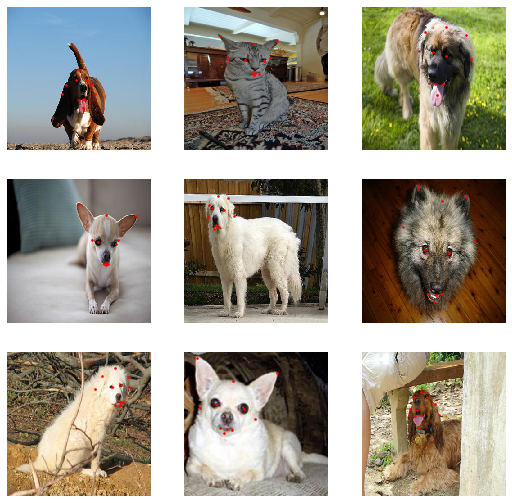

In [8]:
pet_dataloaders = pet_block.dataloaders(
    images_path,
    bs=32
)
pet_dataloaders.c = pet_dataloaders.train.after_item.c
pet_dataloaders.show_batch()

In [9]:
body = create_body(resnet18, pretrained=True)
head = create_head(nf=1024, n_out=22)
arch = nn.Sequential(body, head)

In [10]:
def _resnet_split(m): 
    return L(m[0][:6], m[0][6:], m[1:]).map(params)

In [11]:
apply_init(arch[1], nn.init.kaiming_normal_)

In [12]:
learn = Learner(
    pet_dataloaders, 
    arch, 
    loss_func=MSELossFlat(), 
    splitter=_resnet_split,
    opt_func=ranger
)
learn.path = Path('..')

In [13]:
learn.freeze()

(0.03019951581954956, 0.14454397559165955)

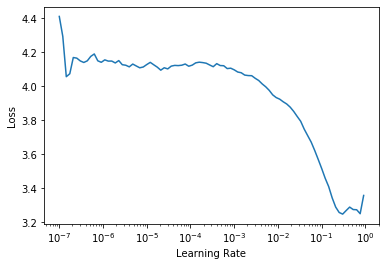

In [14]:
learn.lr_find()

In [15]:
learn.fit_flat_cos(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.681307,0.087241,01:07
1,0.123445,0.068412,01:06
2,0.082416,0.044885,01:07
3,0.057778,0.037140,01:07
4,0.031138,0.014889,01:06


In [16]:
learn.save('top_layer')

In [18]:
learn = learn.load('top_layer')

In [19]:
learn.unfreeze()

(3.6307804407442747e-08, 3.019951861915615e-07)

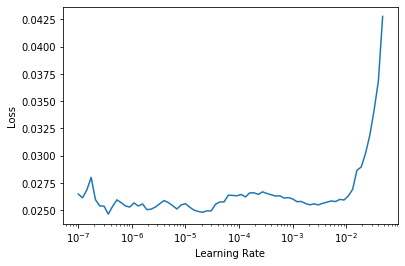

In [20]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.022647,0.012159,01:23
1,0.018804,0.016933,01:23
2,0.015906,0.012569,01:23
3,0.015657,0.008933,01:24
4,0.014690,0.008403,01:23
5,0.013350,0.006129,01:24
6,0.011798,0.007698,01:24
7,0.011090,0.008784,01:24
8,0.009596,0.005801,01:24
9,0.008683,0.004212,01:23


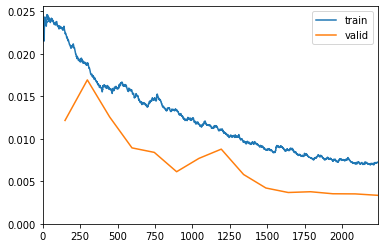

In [21]:
learn.fit_one_cycle(15, 1e-4, cbs=[SaveModelCallback(), ShowGraphCallback()])

In [16]:
learn = learn.load('model')

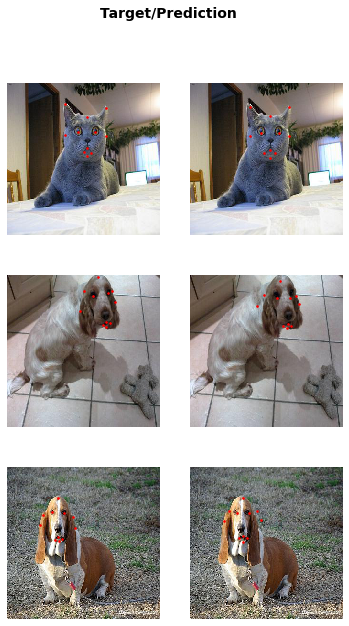

In [23]:
learn.show_results()

In [18]:
# learn.predict(pet_dataloaders.train_ds.items[0])

In [24]:
# learn.summary()